In [1]:
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm

In [43]:
plt.style.use('seaborn-v0_8-paper')
pt = 1./72.27
fig_width = 239 * pt
aspect_ratio = (1 + 8 ** 0.5) / 2
plt.rcParams["figure.figsize"] = (fig_width, fig_width/aspect_ratio)
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.17
sns.set_theme(style='whitegrid', context='paper', rc={'axes.facecolor': 'white', 'figure.figsize': (fig_width, fig_width/aspect_ratio)})
# sns.set_theme(style='whitegrid', context='paper', rc={'savefig.transparent': 'true', 'figure.figsize': (fig_width, fig_width/aspect_ratio)})
colors = ["#00a1de", "#009b3a", "#c60c30", "#532A92", "#f9461c", "#e27ea6", "#f9e300", "#62361b"]
anon_name = "IC"

In [44]:
def create_plots(file, experiment_name, drop_machines=False):
    df = pd.read_csv(file)
    df.columns = df.columns.str.replace(' ', '')
    user_map = ["Greedy", "Energy", "EFT", "Unknown", "Unknown", "Theta", anon_name, "FASTER", "Mixed", "Runtime"]
    df["user_name"] = df["User_id"].apply(lambda uid : user_map[uid])
    df = df[df["user_name"] != "Unknown"]
    df['user_name'] = pd.Categorical(df['user_name'], ['Greedy', 'Energy', 'Mixed', 'EFT', 'Runtime', 'Theta', anon_name, 'FASTER'])

    df["work_per_job"] = (df["Number_of_cores_used"] * (df["Mean_duration_on_machines"] / 3600)) / 1000000
    df["job_end_time_hours"] = df["Job_end_time"] / (60 * 60)
    
    df = df.sort_values(by='Job_end_time')
    data = df[df["New_credit"] >= 0]
    data["work_completed"] = data.groupby(["user_name"])["work_per_job"].cumsum()
    data["jobs_completed"] = data.groupby(["user_name"])["Credit_lost"].cumcount() / 1000
    
    if drop_machines:
        data = data[data["user_name"] != "Theta"]
        data = data[data["user_name"] != "FASTER"]
        data = data[data["user_name"] != anon_name]
    
    fig, ax = plt.subplots()
    sns.histplot(data=data, x="user_name", hue="user_name", shrink=0.75, palette=colors, legend=False, alpha=1, ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel("Jobs Finished")
    ax.tick_params(axis='x', labelrotation=45)
    plt.savefig(f"sim_{experiment_name}_jobs_completed.pdf")
    plt.savefig(f"sim_{experiment_name}_jobs_completed_talk.png")
    plt.show()
    
    display(data["user_name"].value_counts())
    
    fig, ax = plt.subplots()
    sns.histplot(data=data, x="user_name", hue="user_name", weights="work_per_job", shrink=0.75, palette=colors, legend=False, alpha=1, ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel("Core Hours\n(Mil.)")
    ax.tick_params(axis='x', labelrotation=45)
    plt.savefig(f"sim_{experiment_name}_work_completed.pdf")
    plt.savefig(f"sim_{experiment_name}_work_completed_talk.png")
    plt.show()
    
    fig, ax = plt.subplots()
    sns.lineplot(data=data, x="job_end_time_hours", y="jobs_completed", hue="user_name", hue_order=['Greedy', 'Energy', 'Mixed', 'EFT', 'Runtime', 'Theta', anon_name, 'FASTER'], palette=colors, ax=ax)
    ax.set_xlabel("Elapsed Time (hours)")
    ax.set_ylabel("Jobs Finished\n(Thous.)")
    sns.move_legend(ax, "center right", bbox_to_anchor=(1.00, .5), ncol=1, title=None, fontsize=7)
    plt.savefig(f"sim_{experiment_name}_jobs_vs_time.pdf")
    plt.savefig(f"sim_{experiment_name}_jobs_vs_time_talk.png")
    plt.show()
    
    endpoint_map = ["Theta", anon_name, "Desktop", "FASTER"]
    df["endpoint_name"] = df["Selected_endpoint"].apply(lambda eid : endpoint_map[eid])
    data = df[df["user_name"] != "Theta"]
    data = data[data["user_name"] != "FASTER"]
    data = data[data["user_name"] != anon_name]

    fig, ax = plt.subplots()
    sns.histplot(data, x="user_name", hue="endpoint_name", hue_order=["IC", "FASTER", "Desktop", "Theta"], multiple="stack", shrink=0.75, ax=ax)
    sns.move_legend(ax, "center right", bbox_to_anchor=(1.0, .75), ncol=1, title=None, fontsize=7)
    ax.set_xlabel(None)
    ax.set_ylabel("Jobs Finished\n(Thous.)")
    labels = np.array([int(l.get_text()) for l in ax.get_yticklabels()]) / 1000
    ax.set_yticklabels(labels)
    plt.savefig(f"sim_{experiment_name}_distribution.pdf")
    plt.savefig(f"sim_{experiment_name}_job_distribution_talk.png")
    plt.show()

/tmp/ipykernel_1007/631731923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["work_completed"] = data.groupby(["user_name"])["work_per_job"].cumsum()
/tmp/ipykernel_1007/631731923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["jobs_completed"] = data.groupby(["user_name"])["Credit_lost"].cumcount() / 1000


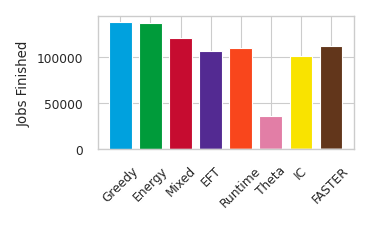

Greedy     137860
Energy     137153
Mixed      121295
FASTER     112661
Runtime    109750
EFT        106934
IC         101313
Theta       35555
Name: user_name, dtype: int64

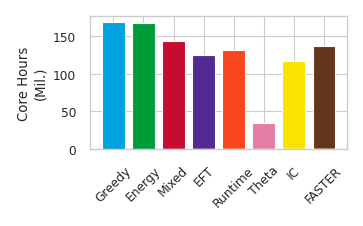

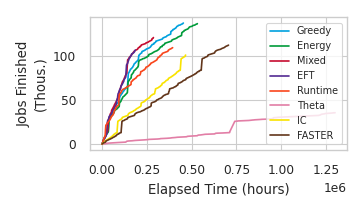

/tmp/ipykernel_1007/631731923.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


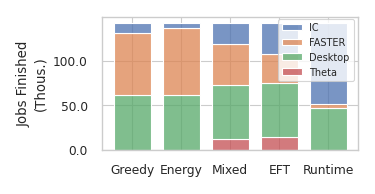

In [45]:
create_plots("../outputs/set_of_endpoints_1_meggie_and_emmy_count_from_database_credit.csv", "eba")

/tmp/ipykernel_1007/631731923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["work_completed"] = data.groupby(["user_name"])["work_per_job"].cumsum()
/tmp/ipykernel_1007/631731923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["jobs_completed"] = data.groupby(["user_name"])["Credit_lost"].cumcount() / 1000


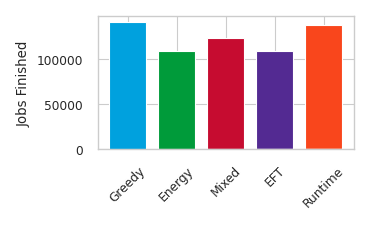

Greedy     140299
Runtime    137544
Mixed      122817
EFT        109015
Energy     108706
Theta           0
IC              0
FASTER          0
Name: user_name, dtype: int64

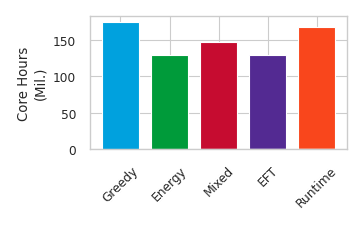

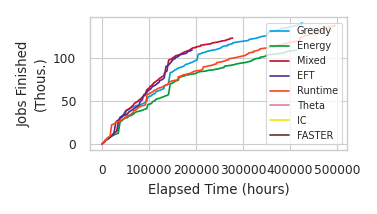

/tmp/ipykernel_1007/631731923.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


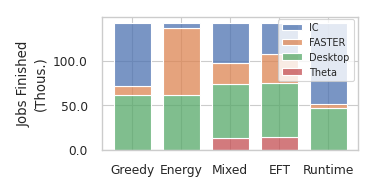

In [46]:
create_plots("../outputs/set_of_endpoints_1_meggie_and_emmy_count_from_database_carbon.csv", "carbon", drop_machines=True)

In [47]:
(108706/140299)/(137153/137860)

0.7788106874157676

In [48]:
(137544/140299)/(109750/137860)

1.23146144645423

/tmp/ipykernel_1007/631731923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["work_completed"] = data.groupby(["user_name"])["work_per_job"].cumsum()
/tmp/ipykernel_1007/631731923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["jobs_completed"] = data.groupby(["user_name"])["Credit_lost"].cumcount() / 1000


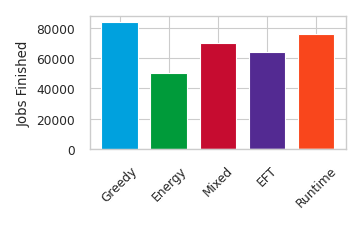

Greedy     83533
Runtime    75634
Mixed      69781
EFT        63841
Energy     50354
Theta          0
IC             0
FASTER         0
Name: user_name, dtype: int64

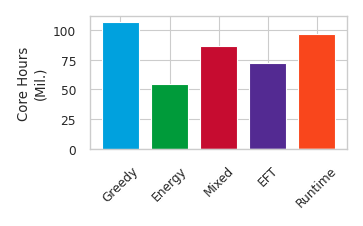

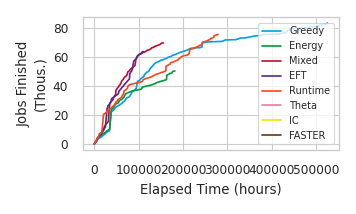

/tmp/ipykernel_1007/631731923.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


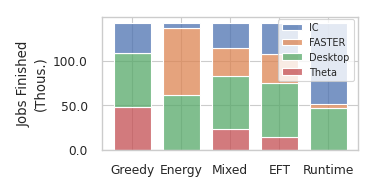

In [49]:
create_plots("../outputs/set_of_endpoints_2_meggie_and_emmy_count_from_database_carbon.csv", "reduced_carbon", drop_machines=True)

In [40]:
dataframes = {}
for i in tqdm.tqdm(range(24)):
    df = pd.read_csv(f"../outputs/slice_{i}")
    df.columns = df.columns.str.replace(' ', '')
    user_map = ["Greedy", "Energy", "EFT", "Unknown", "Unknown", "Theta", anon_name, "FASTER", "Mixed", "Runtime"]
    df["user_name"] = df["User_id"].apply(lambda uid : user_map[uid])
    data = df[df["user_name"] == "Greedy"]
    
    data = data.sort_values(by='Job_end_time')
    endpoint_map = ["Theta", anon_name, "Desktop", "FASTER"]
    data["endpoint_name"] = data["Selected_endpoint"].apply(lambda eid : endpoint_map[eid])
    data["slice"] = i
    dataframes[i] = data["endpoint_name"].value_counts(normalize=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:13<00:00,  8.06s/it]


In [41]:
df = pd.DataFrame.from_dict(dataframes, orient="index")
df = df.reset_index(names="slice")
df = df.melt(id_vars="slice")
df["slice"] = df["slice"].astype(str)

/tmp/ipykernel_1007/628350539.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


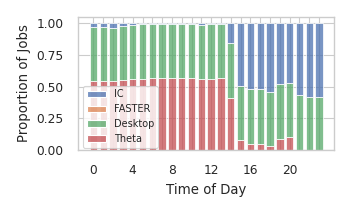

In [50]:
fig, ax = plt.subplots()
sns.histplot(df, x="slice", hue="variable", multiple="stack", weights="value", hue_order=["IC", "FASTER", "Desktop", "Theta"], shrink=0.75, ax=ax)
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.37, 1.05), ncol=4, title=None, fontsize=8)
sns.move_legend(ax, "center left", bbox_to_anchor=(0, .25), ncol=1, title=None, fontsize=7)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Proportion of Jobs")
labels = ["" for _ in ax.get_xticklabels()]
labels[::4] = ax.get_xticklabels()[::4]
ax.set_xticklabels(labels)
plt.savefig("sim_job_distribution_over_time.pdf")

In [27]:
carbon_files = ["../inputs/carbon/AU-SA_2023_hourly.csv", "../inputs/carbon/CA-ON_2023_hourly.csv", "../inputs/carbon/NO-NO2_2023_hourly.csv", "../inputs/carbon/DK-BHM_2023_hourly.csv"]
carbon_dataframes = []
for file in carbon_files:
    carbon_df = pd.read_csv(file)
    carbon_dataframes.append(carbon_df.iloc[:24])
    
carbon_df = pd.concat(dataframes)

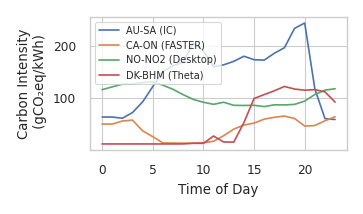

In [51]:
endpoint_map = {
    "DK-BHM": "DK-BHM (Theta)",
    "AU-SA": "AU-SA (IC)",
    "CA-ON": "CA-ON (FASTER)",
    "NO-NO2": "NO-NO2 (Desktop)"
}
fig, ax = plt.subplots()
carbon_df["Zone"] = carbon_df["Zone Id"].apply(lambda x : endpoint_map[x])
carbon_df["Time of Day"] = pd.to_datetime(carbon_df['Datetime (UTC)']).dt.hour
sns.lineplot(carbon_df, x="Time of Day", y="Carbon Intensity gCO₂eq/kWh (LCA)", hue="Zone", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1.0), ncol=1, title=None, fontsize=7)
ax.set_ylabel("Carbon Intensity\n (gCO₂eq/kWh)")
plt.savefig("sim_carbon_intensity_over_time.pdf")